### VCM Research

### Difference-in-Differences


In [22]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import qvalue
import geopandas 

### Equation 1

In [3]:
file_path = '/Users/f/Desktop/VCM_IS-R.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='surplus').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['surplus'] = pd.to_numeric(df['surplus'])

df 

,Project ID,Registry,Voluntary Status,Scope,Type,Country,Total_Credits,years,surplus
0,ACR102,ACR,Completed,Chemical_Processes,Reduction,United States of America,7984006,2004,0
1,ACR103,ACR,Completed,Agriculture,Reduction,United States of America,44202,2004,0
2,ACR106,ACR,Completed,Waste_Management,Reduction,United States of America,138492,2004,0
3,ACR107,ACR,Completed,Industrial_Manufacturing,Reduction,Bolivia,1138,2004,0
4,ACR109,ACR,Registered,Industrial_Manufacturing,Reduction,United States of America,541804,2004,0
...,...,...,...,...,...,...,...,...,...
61285,VCS995,VCS,Registered,Forestry_Land_Use,Removal,Uganda,168442,2021,19767
61286,VCS996,VCS,Registered,Forestry_Land_Use,Removal,Kenya,299772,2021,113991
61287,VCS998,VCS,Registered,Household_Community,Reduction,Vietnam,32897,2021,0
61288,VCSOPR10,VCS,Transfer to another GHG program,Forestry_Land_Use,Mixed,United States of America,97193,2021,0


In [4]:
grouped = df.groupby('Country')
summary = grouped['Project ID'].nunique().reset_index(name='N')
summary = pd.merge(summary, grouped['surplus'].describe()[['mean', 'std', 'min', 'max']].round(), on='Country')

df_summary = pd.DataFrame(summary)

df_summary

,Country,N,mean,std,min,max
0,Argentina,8,11104.0,78078.0,-86986.0,669564.0
1,Aruba,1,17033.0,119997.0,-229077.0,292784.0
2,Australia,5,95.0,29777.0,-85504.0,119404.0
3,Bangladesh,38,6912.0,168251.0,-23403.0,4400001.0
4,Belize,4,20426.0,210068.0,-235632.0,1655926.0
...,...,...,...,...,...,...
93,United States of America,770,7287.0,166637.0,-6390607.0,7143740.0
94,Uruguay,10,47631.0,394519.0,-1003683.0,4264288.0
95,Vietnam,40,4998.0,60846.0,-736775.0,817964.0
96,Zambia,16,11167.0,220148.0,-843209.0,3535620.0


In [5]:
# Specify the treatment group

treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Fit the model using the ols function
model = smf.ols(formula = 'surplus ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.26
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           3.50e-20
Time:                        17:31:27   Log-Likelihood:            -8.3852e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61286   BIC:                         1.677e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

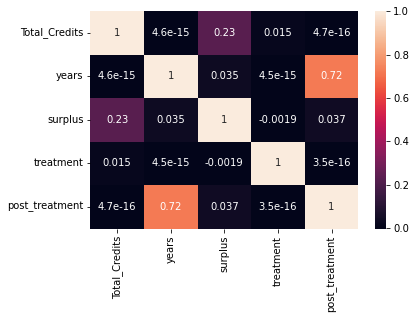

In [6]:
#print corr_matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

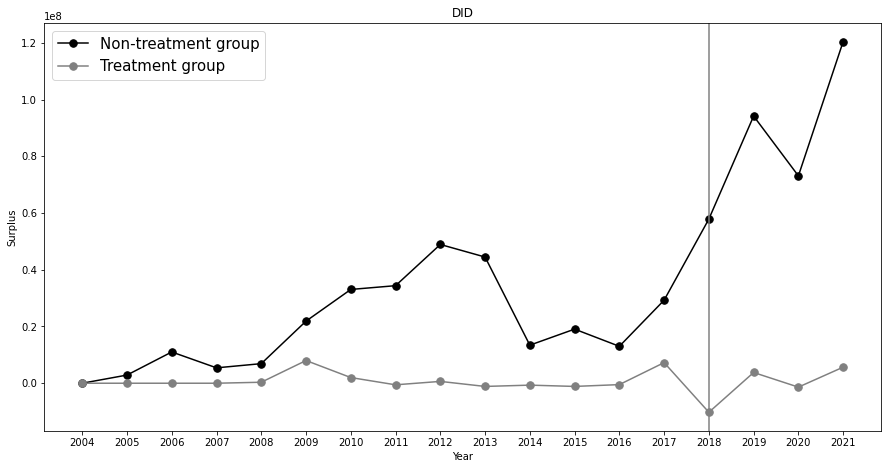

In [7]:
# Create a pivot table to summarize the surplus by year and treatment
ax = df.pivot_table(values='surplus', index='years', columns='treatment', aggfunc='sum').plot(
    figsize=(15, 7.5),
    marker='.', 
    markersize=15, 
    title='DID',
    xlabel='Year',
    ylabel='Surplus',
    # Set the x-axis ticks to match the years in the dataframe
    xticks=df['years'].drop_duplicates().sort_values().astype('int'),
    color=['black', 'gray']
)

# Add a vertical line to show the year of the policy change
ax.axvline(x=2018, color='gray', linestyle='-')
ax.legend(['Non-treatment group', 'Treatment group'], fontsize=15)

/Users/f/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


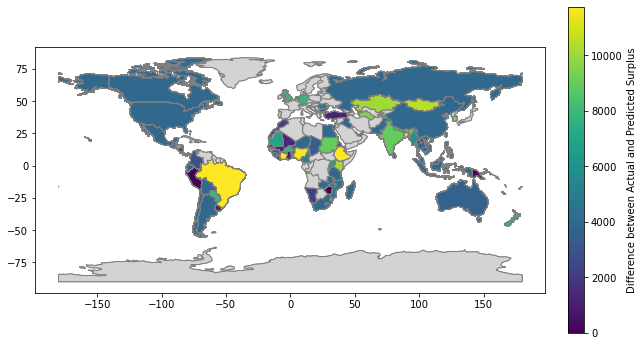

In [14]:
# Predict the surplus using the model
df['predicted_surplus'] = model.predict()

# Calculate the difference between actual and predicted surplus
df['difference'] = df['surplus'] - df['predicted_surplus']

# Load the GeoDataFrame with country borders
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame for the missing countries
missing_countries = world[~world['name'].isin(df['Country'])].copy()
missing_countries.loc[:, 'difference'] = None

# Merge the GeoDataFrame with the results of the model
result = world.merge(df, left_on='name', right_on='Country', how='outer')
result = pd.concat([result, missing_countries], ignore_index=True, sort=False)

# Plot the choropleth map
ax = result.plot(column='difference', cmap='viridis', figsize=(10, 6), edgecolor='gray', missing_kwds={'color': 'lightgray'})

# Add a color bar
cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Difference between Actual and Predicted Surplus')

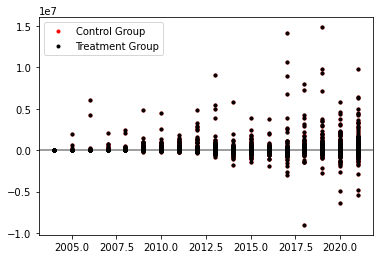

In [8]:
import statsmodels.formula.api as smf

# Fit a model without the treatment effect
control_model = smf.ols(formula = 'surplus ~ post_treatment', data = df).fit()

# Fit the full model including the treatment effect
treatment_model = smf.ols(formula = 'surplus ~ treatment + post_treatment + treatment*post_treatment', data = df).fit()

# Calculate the residuals for both models
df['residual_control'] = control_model.resid
df['residual_treatment'] = treatment_model.resid

# Plot the residuals against the time variable to visualize the parallel trend assumption
import matplotlib.pyplot as plt

plt.plot(df['years'], df['residual_control'], '.', label='Control Group', color = 'red')
plt.plot(df['years'], df['residual_treatment'], '.', label='Treatment Group', color = 'black')

plt.axhline(y=0, linestyle='-', color='black', alpha=0.5)
plt.legend()
plt.show()


### Placebo test 

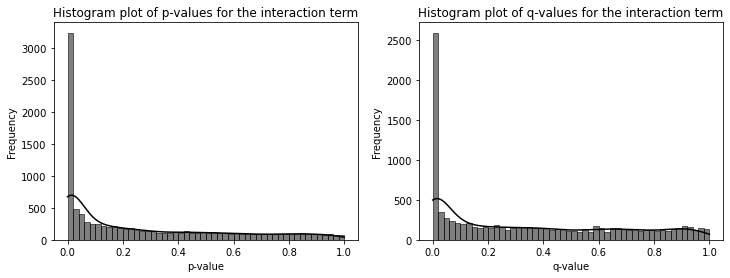

In [52]:
p_values = []

for i in range(10000):
    # set the seed for the random process
    random.seed(i)
    
    # create a list of countries that are not in the treatment group
    countries = list(set(countries for countries in df["Country"] if countries not in treatment_group))

    # select a random sample of countries from the list of non-treatment countries 
    # that has the same number of elements as the treatment group
    placebo_group = random.sample(countries, len(treatment_group))

    # create a new column in the dataframe indicating whether each country is in the placebo group
    df['placebo_treatment'] = df['Country'].isin(placebo_group).astype(int)

    # create a new column indicating whether the observation is post-treatment
    df['post_placebo_treatment'] = (df['years'] >= 2018).astype(int)

    model = smf.ols(formula = 'surplus ~ placebo_treatment + post_placebo_treatment + placebo_treatment*post_placebo_treatment', data = df).fit()

    p_values.append(model.pvalues[3])


rejected, q_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
   
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(p_values, bins = 50, kde = True, color = 'black', ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("p-value")
ax[0].set_title("Histogram plot of p-values for the interaction term")

sns.histplot(q_values, bins = 50, kde = True, color = 'black', ax=ax[1])
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("q-value")
ax[1].set_title("Histogram plot of q-values for the interaction term")

plt.show()

### Equation 2

In [32]:
file_path = '/Users/f/Desktop/VCM_IS-R.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='surplus').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['surplus'] = pd.to_numeric(df['surplus'])

# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay','New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

df = pd.get_dummies(df, columns=['Type'], prefix='Type')

project_types = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Manufacturing', 'Renewable_Energy', 'Transportation','Waste_Management']

df_dummies = pd.get_dummies(df['Scope'], columns=project_types)

df = pd.concat([df, df_dummies], axis=1)

project_types = ['Type_Reduction', 'Type_Removal', 'Type_Mixed']
dummy_cols = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Manufacturing', 'Renewable_Energy', 'Transportation', 'Waste_Management']

# Divide Total_Credits into categories
df['credit_size'] = pd.cut(df['Total_Credits'], 
                           bins=[0, 10000, 100000, 10000000, np.inf], 
                           labels=['less_than_10000', '10000_to_100000', '1000000_to_10000000', 'exceeding_10000000'])


df = pd.get_dummies(df, columns=['credit_size'], prefix='credit_size')

df = pd.get_dummies(df, columns=['Registry'], prefix='Registry')

# Get the names of the new dummy columns created
credit_size_dummies = [col for col in df.columns if 'credit_size' in col]

results = []

for project_type in project_types:
    for dummy_col in dummy_cols:
        for credit_size in credit_size_dummies:
            for registry in ['Registry_ACR', 'Registry_CAR', 'Registry_GOLD', 'Registry_VCS']:
                formula = f'surplus ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col} + {credit_size} + {registry}'
                model = smf.ols(formula=formula, data=df).fit()
                results.append(model)


### Results

In [25]:
for result in results:
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     40.67
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           1.53e-57
Time:                        17:46:23   Log-Likelihood:            -8.3843e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     50.54
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           3.19e-72
Time:                        17:46:23   Log-Likelihood:            -8.3840e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     40.21
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           7.34e-57
Time:                        17:46:23   Log-Likelihood:            -8.3843e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     320.4
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:46:23   Log-Likelihood:            -8.3747e+05
No. Observations:               61290   AIC:                         1.675e+06
Df Residuals:                   61282   BIC:                         1.675e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     321.9
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:46:23   Log-Likelihood:            -8.3747e+05
No. Observations:               61290   AIC:                         1.675e+06
Df Residuals:                   61282   BIC:                         1.675e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     45.24
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           2.42e-64
Time:                        17:46:24   Log-Likelihood:            -8.3841e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     51.01
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           6.30e-73
Time:                        17:46:24   Log-Likelihood:            -8.3839e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     50.59
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           2.68e-72
Time:                        17:46:24   Log-Likelihood:            -8.3840e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.53
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           2.63e-26
Time:                        17:46:24   Log-Likelihood:            -8.3850e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     27.42
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           6.78e-38
Time:                        17:46:24   Log-Likelihood:            -8.3848e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     315.6
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:46:25   Log-Likelihood:            -8.3749e+05
No. Observations:               61290   AIC:                         1.675e+06
Df Residuals:                   61282   BIC:                         1.675e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     18.96
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           1.82e-25
Time:                        17:46:25   Log-Likelihood:            -8.3851e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.01
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           1.54e-25
Time:                        17:46:25   Log-Likelihood:            -8.3851e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     28.22
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           4.47e-39
Time:                        17:46:25   Log-Likelihood:            -8.3847e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     32.17
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           6.40e-45
Time:                        17:46:25   Log-Likelihood:            -8.3846e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.75
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           1.51e-29
Time:                        17:46:26   Log-Likelihood:            -8.3850e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     321.8
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:46:26   Log-Likelihood:            -8.3747e+05
No. Observations:               61290   AIC:                         1.675e+06
Df Residuals:                   61282   BIC:                         1.675e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     45.13
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           3.63e-64
Time:                        17:46:26   Log-Likelihood:            -8.3841e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     322.0
Date:                Sun, 12 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:46:26   Log-Likelihood:            -8.3746e+05
No. Observations:               61290   AIC:                         1.675e+06
Df Residuals:                   61282   BIC:                         1.675e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     45.94
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           2.22e-65
Time:                        17:46:27   Log-Likelihood:            -8.3841e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     51.83
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           3.79e-74
Time:                        17:46:27   Log-Likelihood:            -8.3839e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     51.79
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           4.36e-74
Time:                        17:46:27   Log-Likelihood:            -8.3839e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     51.33
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           2.10e-73
Time:                        17:46:27   Log-Likelihood:            -8.3839e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     45.54
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           8.63e-65
Time:                        17:46:27   Log-Likelihood:            -8.3841e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61282   BIC:                         1.677e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [27]:
results = []
columns = ['Project Type', 'Scope', 'Credit Size', 'Registry', 'Standard Error', 'P-Value']
results_df = pd.DataFrame(columns=columns)

for project_type in project_types:
    for dummy_col in dummy_cols:
        for credit_size in credit_size_dummies:
            for registry in ['Registry_ACR', 'Registry_CAR', 'Registry_GOLD', 'Registry_VCS']:
                formula = f'surplus ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col} + {credit_size} + {registry}'
                model = smf.ols(formula=formula, data=df).fit()
                results.append({'Project Type': project_type, 'Scope': dummy_col, 'Credit Size': credit_size, 'Registry': registry, 
                                'Standard Error': round(model.bse[-1], 2), 'P-Value': round(model.pvalues[-1], 2)})

results_df = results_df.append(results, ignore_index=True)

results_df

/var/folders/3f/1rvnnl6n78163t47_hmr870h0000gn/T/ipykernel_88390/330098440.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results, ignore_index=True)


,Project Type,Scope,Credit Size,Registry,Standard Error,P-Value
0,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_ACR,3750.74,0.99
1,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_CAR,2565.65,0.0
2,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_GOLD,1896.1,0.03
3,Type_Reduction,Agriculture,credit_size_less_than_10000,Registry_VCS,1761.52,0.0
4,Type_Reduction,Agriculture,credit_size_10000_to_100000,Registry_ACR,3745.4,0.63
...,...,...,...,...,...,...
427,Type_Mixed,Waste_Management,credit_size_1000000_to_10000000,Registry_VCS,1767.8,0.0
428,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_ACR,3691.29,0.46
429,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_CAR,2445.52,0.0
430,Type_Mixed,Waste_Management,credit_size_exceeding_10000000,Registry_GOLD,1846.94,0.14


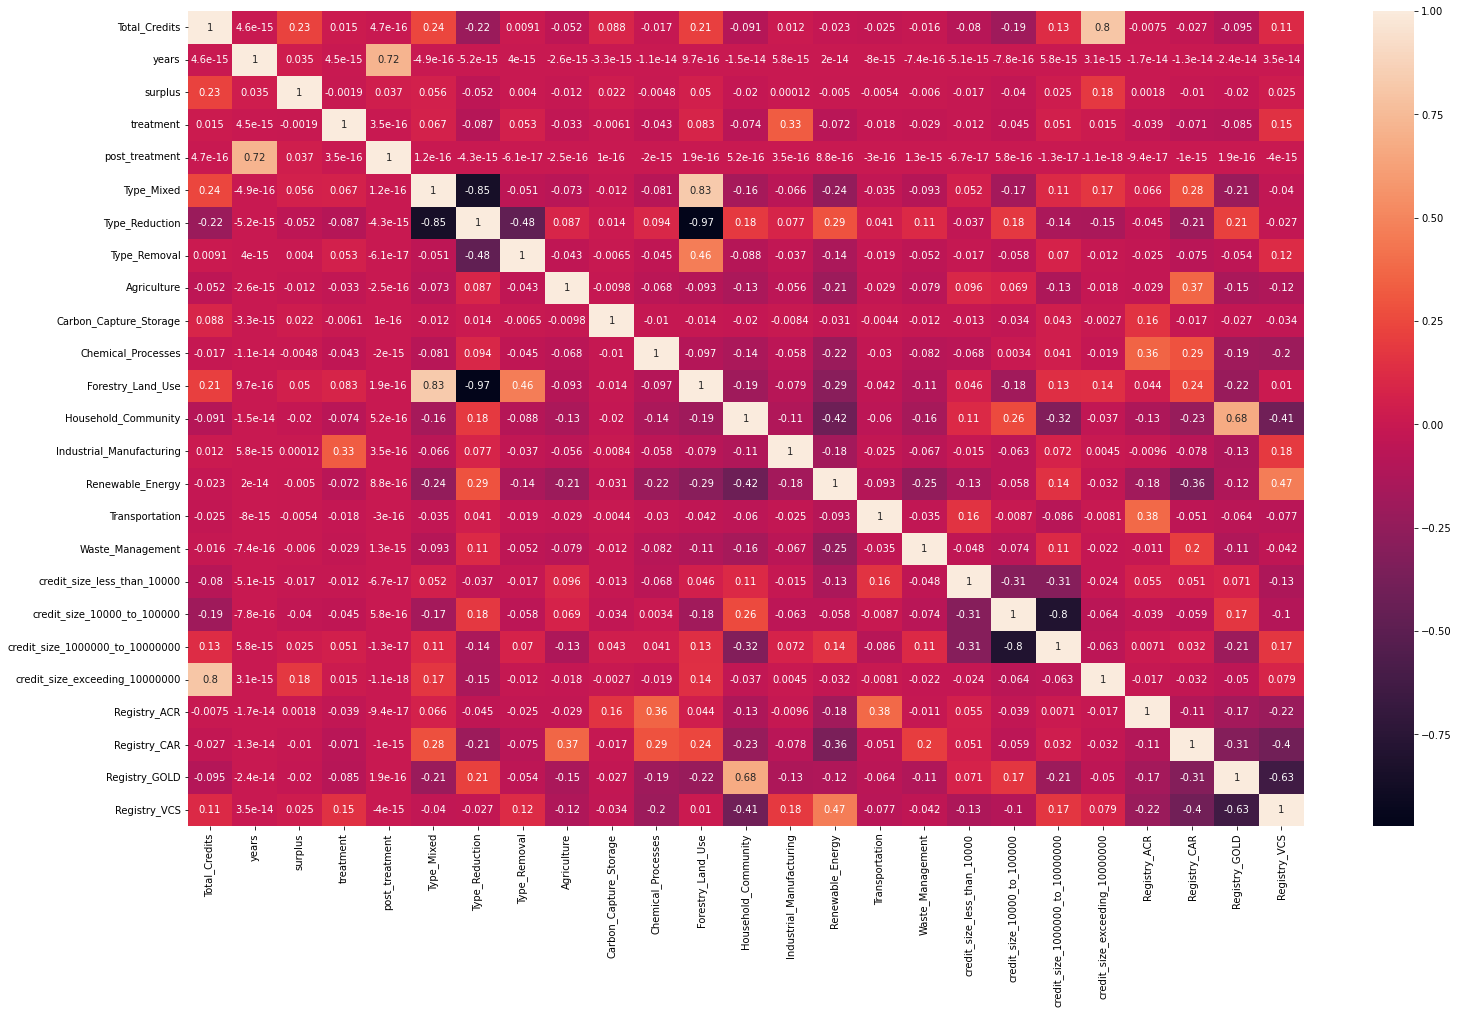

In [93]:
#print corr_matrix for all variables in equation 2
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, ax=ax)

plt.show()

### Alternative Approach

In [78]:
file_path = '/Users/f/Desktop/VCM_IS-R.csv'

# open the file and store the data in a data frame
df = pd.read_csv(file_path, low_memory=False)

# melt years columns
columns_to_melt = [str(i) for i in range(2004, 2022)]

# Melt the selected columns, using the column names as the id_vars
df = pd.melt(df, id_vars=['Project ID', 'Registry', 'Voluntary Status', 'Scope', 'Type', 'Country', 'Total_Credits'], 
             value_vars=columns_to_melt, var_name='years', value_name='surplus').dropna()

# Convert years to numeric
df['years'] = pd.to_numeric(df['years'])

# Convert surplus to numeric
df['surplus'] = pd.to_numeric(df['surplus'])

# Specify the treatment group
treatment_group = ['Switzerland', 'Belize', 'Spain', 'Costa Rica', 'Paraguay', 
                   'New Zealand', 'Germany', 'United Kingdom', 'Colombia', 'Fiji']

# Create treatment and post_treatment columns
df['treatment'] = df['Country'].isin(treatment_group).astype(int)
df['post_treatment'] = (df['years'] >= 2018).astype(int)

# Divide Total_Credits into categories
df['credit_size'] = pd.cut(df['Total_Credits'], 
                           bins=[0, 10000, 100000, 10000000, np.inf], 
                           labels=['less than 10,000', '10,000 to 100,000', '1,000,000 to 10,000,000', 'exceeding 10,000,000'])

# Fit separate regression models for each category of Total_Credits
for size in df['credit_size'].unique():
    credit_size_df = df[df['credit_size'] == size]
    model = smf.ols(formula = 'surplus ~ treatment + post_treatment + treatment*post_treatment', data = credit_size_df).fit()
    print(f"Model for credit size: {size}")
    print(model.summary())

Model for credit size: 1,000,000 to 10,000,000
                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     48.23
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           4.44e-31
Time:                        16:27:23   Log-Likelihood:            -3.6814e+05
No. Observations:               27144   AIC:                         7.363e+05
Df Residuals:                   27140   BIC:                         7.363e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [79]:
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

project_types = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use',
                 'Household_Community', 'Industrial_Manufacturing', 'Renewable_Energy', 'Transportation',
                 'Waste_Management']

df_dummies = pd.get_dummies(df['Scope'], columns=project_types)

df = pd.concat([df, df_dummies], axis=1)

project_types = ['Type_Reduction', 'Type_Removal', 'Type_Mixed']
dummy_cols = ['Agriculture', 'Carbon_Capture_Storage', 'Chemical_Processes', 'Forestry_Land_Use','Household_Community', 'Industrial_Manufacturing', 'Renewable_Energy', 'Transportation', 'Waste_Management']

results = []

for project_type in project_types:
    for dummy_col in dummy_cols:
        formula = f'surplus ~ treatment + post_treatment + treatment*post_treatment + {project_type} + {dummy_col}'
        model = smf.ols(formula=formula, data=df).fit()
        results.append(model)

# You can access the summary of each regression by using:
for result in results:
    print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                surplus   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     52.88
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           5.90e-55
Time:                        16:28:01   Log-Likelihood:            -8.3844e+05
No. Observations:               61290   AIC:                         1.677e+06
Df Residuals:                   61284   BIC:                         1.677e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               